## Deep Learning with Radio Ineterferometers

In this notebook, we are trying to use radio visibilities and neural networks to predict if an antenna will be a good antenna or a bad antenna. DIfferences between the antennas can be subtle, so the goal, initially is to use deep learning to learn features from the visibilities that describe each binary class. 

In [3]:
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Get all the features in a condensed form.
# d1 = np.loadtxt('data/stats_1e2.txt')
# ants = d1[:,0]#antenna numbers
# f1 = d1[:,-1]#standard devs of solved delays
# m,v,f = capo.miriad.read_files(['zen.2456679.43314.xx.uvcRRE'],'auto','xx',verbose=True)
# bad_antennae = [8,14,15,16,26,27,28,34,37,38,42,46,50,53,72,74,82,84,85,110]

# feature_dict = {}
# times = m['times']
# for a,ff in zip(ants,f1):
#    ant_flag = 1
#    if a in bad_antennae: 
#        print 'flagging: ',a 
#        ant_flag = 0
#    for samp,tsample in enumerate(times):
#     feature_dict[a] = [np.hstack((ff,np.real(v[(a,a)]['xx'][time]),ant_flag))]
#        feature_dict[str(a) + str(tsample)] =list(np.hstack((np.real(v[(a,a)]['xx'][samp]),ant_flag)))

Here we read in the data. We have put each positive and negative sample into their own directory. 

In [5]:
pos_sample_dir = 'data/good3'
neg_sample_dir = 'data/bad3'
pos_sample_files = [np.load(f) for f in glob.glob(pos_sample_dir+'/*data.npz')]
neg_sample_files = [np.load(f) for f in glob.glob(neg_sample_dir+'/*data.npz')]

nside = 30

#pos_sample_files2 = [np.load(f) for f in glob.glob(pos_sample_dir+'2/*.npz')]
#neg_sample_files2 = [np.load(f) for f in glob.glob(neg_sample_dir+'2/*.npz')]



pos_samples = np.concatenate([np.real(d['arr_0']) for d in pos_sample_files])
neg_samples = np.concatenate([np.real(d['arr_0']) for d in neg_sample_files])
#pos_samples2 = np.concatenate([np.real(d['arr_0']) for d in pos_sample_files2])
#neg_samples2 = np.concatenate([np.real(d['arr_0']) for d in neg_sample_files2])

We finally reshuffle the data into arrays and make a split between the training and test set 80,20. 

In [6]:
#need to normalize features
Y = np.concatenate([np.ones(pos_samples.shape[0]),np.zeros(neg_samples.shape[0])])
X = np.concatenate([pos_samples,neg_samples])
xshape = X.shape
X = X.reshape(xshape[0],1,xshape[1],xshape[2])
X.shape
#shuffle
samps = np.arange(X.shape[0])
np.random.shuffle(samps)
X = X[samps]
Y = Y[samps]
ntrains = int(len(samps)/1.25)
Xtrain = X[:ntrains]; ytrain = Y[:ntrains]
Xtest = X[ntrains:]; ytest = Y[ntrains:]

As a test, we plot ytrain, and test to make sure that the samples are varying and not constant. Previous iterations had a bug and shuffling was not occuring. 

(13721, 1, 30, 30)


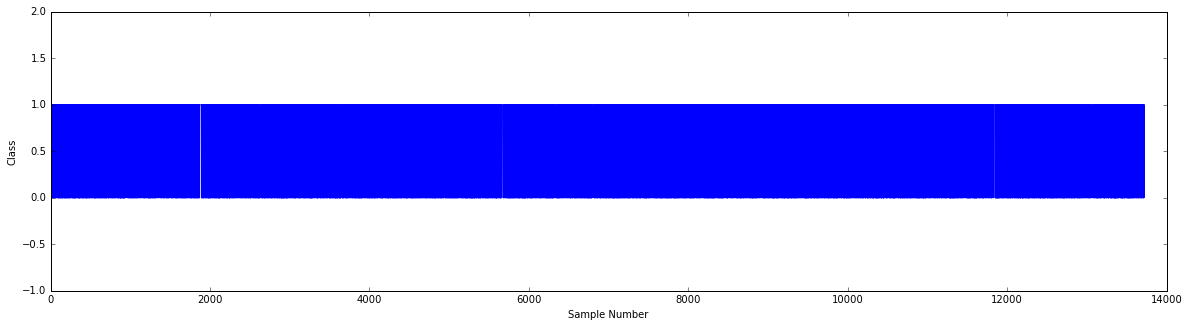

In [7]:
plt.figure(figsize=(20,5))
plt.plot(ytrain)
plt.ylim(-1,2)
plt.xlabel('Sample Number')
plt.ylabel('Class')
print Xtrain.shape

These are examples of a good and a bad antenna. With this data set, there are sligh subtleties, which I cannot pick out by eye. The hope of the neural network is that it picks out features that are indicative of the two classes. After the neural network learns on the data set, we will be to extract the most important features that and then add in some meta features, such as temperature of the system, time of observation, etc... 

In [35]:
def plt_img(goodim, badim, titlegood='Good Antenna after Feature norm', titlebad='Bad Antenna after Feature norm'):
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(goodim)
    plt.title(titlegood)
    plt.xlabel('Channel Number')
    plt.ylabel('Integration Number')
    plt.colorbar(shrink=.5)
    plt.subplot(122)
    plt.imshow(badim)
    plt.title(titlebad)
    plt.xlabel('Channel Number')
    plt.ylabel('Integration Number')
    plt.colorbar(shrink=.5)

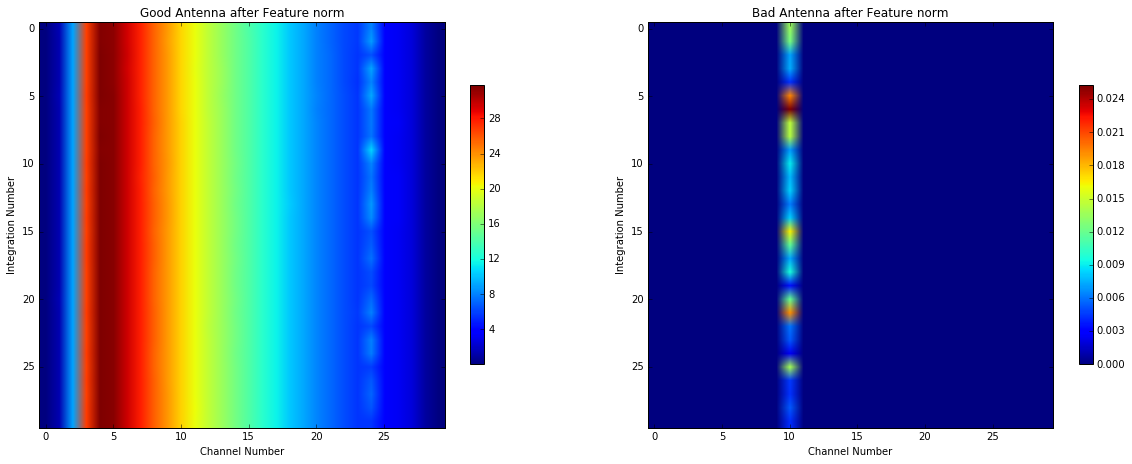

In [36]:
plt_img(Xtrain[np.where(ytrain==1)[0][0]].reshape(nside,nside), Xtrain[np.where(ytrain==0)[0][0]].reshape(nside,nside))


We need to normalize all the images to have the same weights. We do this by subtracting the mean and dividing by the standard deviation, giving us a mean zero and variance 1 feature.

In [9]:
trainmeans = []
trainstdevs = []
testmeans = []
teststdevs = []
Xtrain_norm = np.zeros_like(Xtrain)
Xtest_norm = np.zeros_like(Xtest)
for xx in range(Xtrain.shape[0]):
    trainmeans.append(np.mean(Xtrain[xx]))
    trainstdevs.append(np.std(Xtrain[xx]))
    if trainstdevs[-1] <1e-6: trainstdevs[-1] == 1
    Xtrain_norm[xx] = Xtrain[xx]#(Xtrain[xx] - trainmeans[-1])/trainstdevs[-1]
for xx in range(Xtest.shape[0]):
    testmeans.append(np.mean(Xtest[xx]))
    teststdevs.append(np.std(Xtest[xx]))
    Xtest_norm[xx] = Xtest[xx]#(Xtest[xx] - testmeans[-1])/teststdevs[-1]
    

(13721, 1, 30, 30) (13721,)
(3431, 1, 30, 30) (3431,)


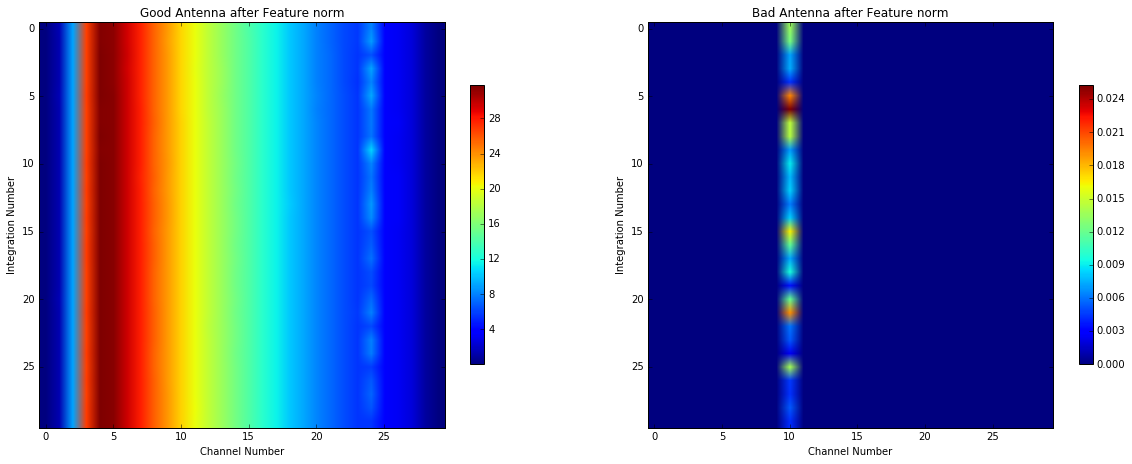

In [37]:
plt_img(Xtrain_norm[np.where(ytrain==1)[0][0]].reshape(nside,nside), Xtrain_norm[np.where(ytrain==0)[0][0]].reshape(nside,nside))
print Xtrain_norm.shape, ytrain.shape
print Xtest_norm.shape,  ytest.shape

Now we use a neural net to train on the data. Currently, we are using convolution layers in the neural net, which is good for images.

In [12]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command:
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
Note: the data was pickled with Python 2, and some encoding issues might prevent you
from loading it in Python 3. You might have to load it in Python 2,
save it in a different format, load it in Python 3 and repickle it.
'''

#from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 32
nb_classes = 2
nb_epoch = 10
data_augmentation = False#True

# input image dimensions
img_rows, img_cols = nside, nside
# the CIFAR10 images are RGB
img_channels = 1

# the data, shuffled and split between train and test sets
print('Xtrain shape:', Xtrain_norm.shape)
print(Xtrain_norm.shape[0], 'train samples')
print(Xtest_norm.shape[0], 'test samples')

# convert class vectors to binary class matrices
Ytrain = np_utils.to_categorical(ytrain, nb_classes)
Ytest = np_utils.to_categorical(ytest, nb_classes)

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
#model.add(Dense(512))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Xtrain = Xtrain_norm.astype('float32')
Xtest = Xtest_norm.astype('float32')

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(Xtrain_norm, Ytrain,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(Xtest_norm, Ytest),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(Xtrain_norm)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(Xtrain_norm, Ytrain,
                        batch_size=batch_size),
                        samples_per_epoch=Xtrain_norm.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(Xtest_norm, Ytest))
    
    model.save('hera_net')

('Xtrain shape:', (13721, 1, 30, 30))
(13721, 'train samples')
(3431, 'test samples')
Not using data augmentation.
Train on 13721 samples, validate on 3431 samples
Epoch 1/10
13721/13721 [==============================] - 450s - loss: 0.0395 - acc: 0.9915 - val_loss: 0.0195 - val_acc: 0.9962
Epoch 2/10
13721/13721 [==============================] - 151s - loss: 0.0223 - acc: 0.9956 - val_loss: 0.0183 - val_acc: 0.9962
Epoch 3/10
13721/13721 [==============================] - 151s - loss: 0.0207 - acc: 0.9956 - val_loss: 0.0180 - val_acc: 0.9962
Epoch 4/10
13721/13721 [==============================] - 151s - loss: 0.0209 - acc: 0.9956 - val_loss: 0.0181 - val_acc: 0.9962
Epoch 5/10
13721/13721 [==============================] - 151s - loss: 0.0208 - acc: 0.9957 - val_loss: 0.0180 - val_acc: 0.9962
Epoch 6/10
13721/13721 [==============================] - 151s - loss: 0.0204 - acc: 0.9956 - val_loss: 0.0179 - val_acc: 0.9962
Epoch 7/10
13721/13721 [==============================] - 151s

Using Theano backend.


In [13]:
#save the model.
#model.save('hera_net')
from keras.models import load_model
model = load_model('hera_net')

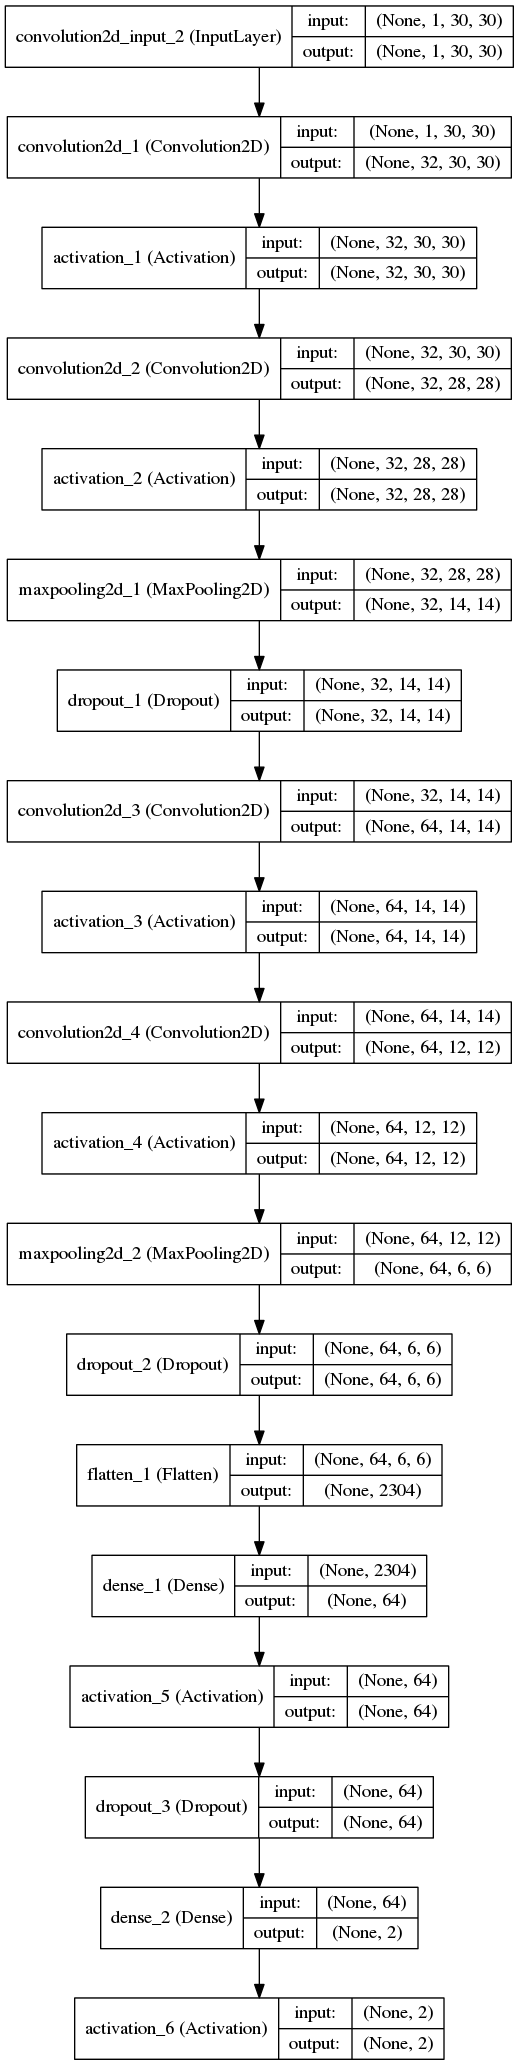

In [88]:
from IPython.core.display import Image 
Image('model.png') 

In [14]:
#look at samples that were classified incorrectly, and correctly, and plot them. 
classes = model.predict_classes(Xtest, batch_size=32)

3431/3431 [==============================] - 13s    


In [15]:
proba = model.predict_proba(Xtest, batch_size=32)

3431/3431 [==============================] - 13s    


(-1, 2)

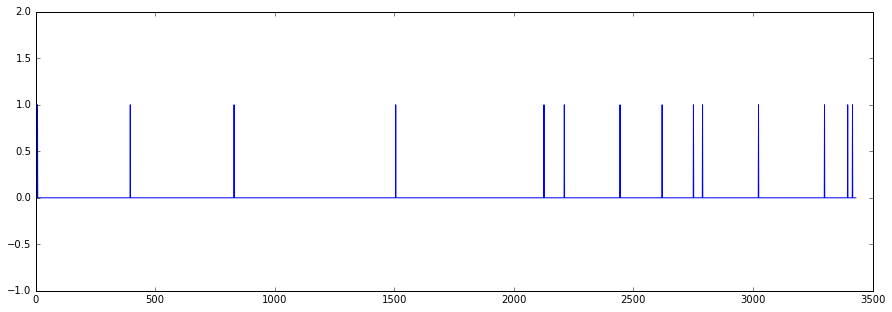

In [18]:
#save the model.
#run on separate data.
plt.figure(figsize=(15,5))
plt.plot(ytest - classes)
plt.ylim(-1,2)
p.xlabel('test sample number')
p.ylabel()

[[1128    0]
 [  14 2289]]


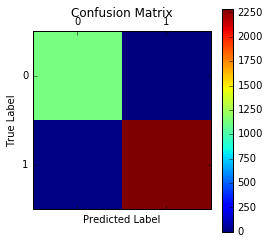

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest,classes)
print cm

plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [54]:
missclass = np.where(np.array(ytest - classes) != 0)[0][-1]
goodclass = np.where(np.array(ytest - classes) == 0)[0][4]
print missclass, goodclass
print ytest[missclass], classes[missclass]
print ytest[goodclass], classes[goodclass]

3416 4
1.0 0
1.0 1


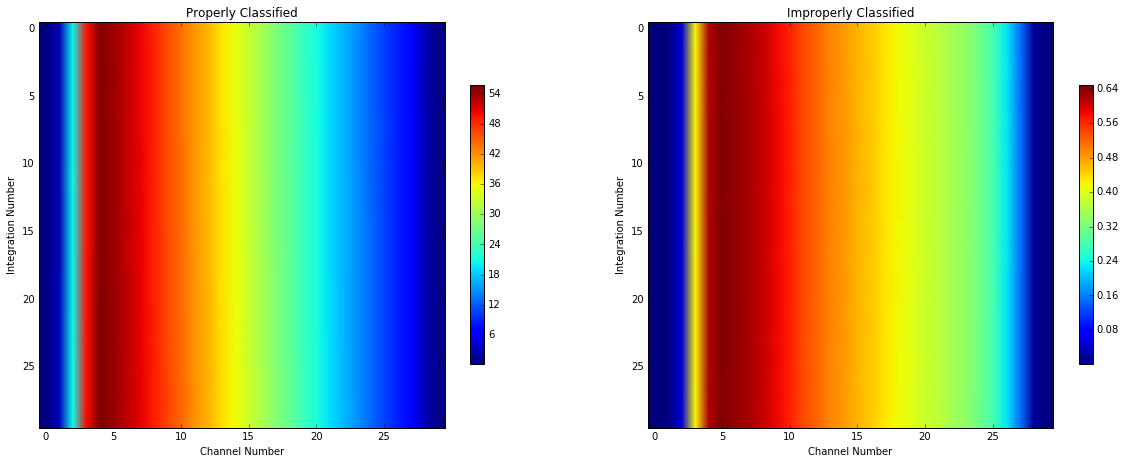

In [55]:
plt_img(Xtest_norm[goodclass].reshape(nside,nside), Xtest_norm[missclass].reshape(nside,nside),titlegood='Properly Classified', titlebad='Improperly Classified')

Well that's weird... the missclassified images actually seem to be mislabelled. The power in the images are much lower than expected for good data. The labelled value for these images are "1", but they are being classidied from the learned model as "0", corresponding to bad antennas. The neural network is so well trained that it can point out my mistakes! Horray! Yay for neural networks!

In [64]:
from keras import backend as K
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[4].output])
layer_output = get_3rd_layer_output([Xtrain_norm])[0]

In [79]:
layer_output.shape

(13721, 32, 14, 14)

In [78]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)
#from IPython.display import SVG
#from keras.utils.visualize_util import mode_to_dot

#SVG(model_to_dot(model).create(prog="dot", format='svg'))

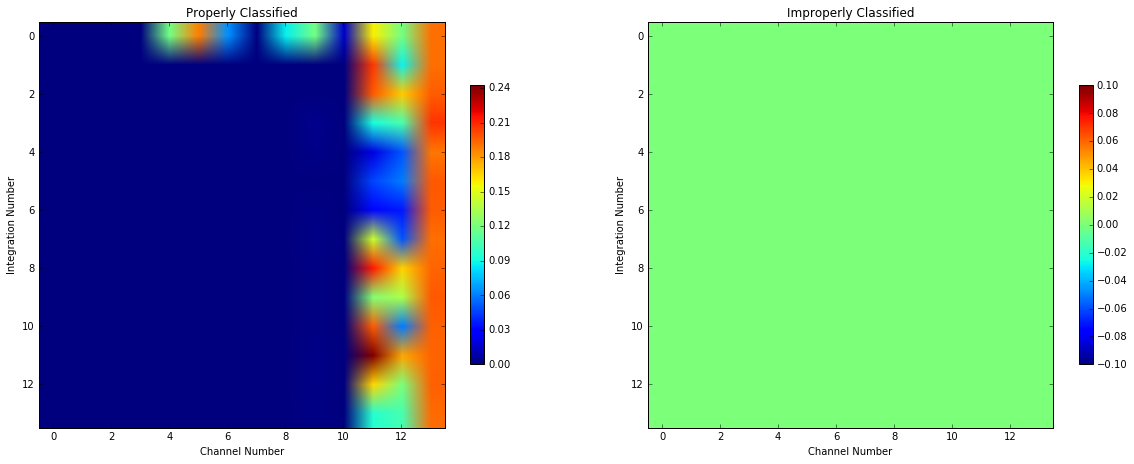

In [87]:
plt_img(layer_output[goodclass][0], layer_output[missclass][0],titlegood='Properly Classified', titlebad='Improperly Classified')

# Whats Next

The first step on this is complete. 
We've successfully run a neural network on visibility (freq vs. time) data sets and predicted on a test set derived from that data set. 

Next steps include varying parameters of the neural network and running the network on other data sets, thus generating different models for different data sets. The ultimate goal is to have one well trained model that is applicable to all the failures found in the instrument. 

Once we have trainied on the models we want to extract the relavant features and include some extra metadata from the instrument and analysis itself, such as time of day, calibration parameters as a function of time, etc... 
Running a random forest classifier on these features for a better predictive model. This is still to come.
